In [185]:
include("../../src/WaterLily.jl")
WaterLily = Main.WaterLily;
using Plots; gr()
using StaticArrays
using JLD
using Images
using FFTW
using Statistics
using Interpolations
using DelimitedFiles
using LinearAlgebra
using PyPlot
using GLMakie
GLMakie.activate!()
using PlotlyJS

In [186]:
inside(a::AbstractArray) = CartesianIndices(map(ax->first(ax)+1:last(ax)-1,axes(a)))
@inline CI(a...) = CartesianIndex(a...)
"""
    δ(i,N::Int)
    δ(i,I::CartesianIndex{N}) where {N}

Return a CartesianIndex of dimension `N` which is one at index `i` and zero elsewhere.
"""
δ(i,::Val{N}) where N = CI(ntuple(j -> j==i ? 1 : 0, N))
δ(i,I::CartesianIndex{N}) where N = δ(i, Val{N}())


δ (generic function with 2 methods)

In [187]:
computationID = "cVOFMyCase"

"cVOFMyCase"

In [188]:
NN = 64
N = (NN,NN,NN)
D = length(N)
Nd = ((N.+2)...,D)

(66, 66, 66, 3)

In [189]:
T=1.5
function leVeque!(u,x,y,z,t)
    half = 0.5/NN
    @. u[:,:,:,1] =   x*(z.+half.+1) *N[1]
    @. u[:,:,:,2] =  -y*(z.+half.+1) *N[2]
    @. u[:,:,:,3] =    (((x.+half).^2+(y.+half).^2).^0.5.+1) *N[3]
    u .*= cos(pi*t/T)
end

function Insidef!(f,dat)
    copyto!(dat,f[inside(f)])
end

Insidef! (generic function with 1 method)

In [190]:
αPlace = zeros(N.+2)
n̂Place = zeros(Nd)

ins = WaterLily.cVOF(
    N,n̂Place,αPlace; 
    InterfaceSDF = (x) -> sqrt.(
        (x[1]-0.17*N[1]-1.5).^2 + (x[2]-0.55*N[2]-1.5).^2 + (x[3]-0.35*N[3]-1.5).^2
    )-N[1]*0.15, 
    perdir=(3,)
)

Main.WaterLily.cVOF{3, Float64, Array{Float64, 3}, Array{Float64, 4}}([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0

In [191]:
typeof(αPlace)

Array{Float64, 3}

In [199]:
t = LinRange(0,T,700)

xList = reshape((1:N[1]+2).-2,(N[1]+2,1,1))/N[1]
yList = reshape((1:N[2]+2).-2,(1,N[2]+2,1))/N[2]
zList = reshape((1:N[3]+2).-2,(1,1,N[3]+2))/N[3]

lx,ly,lz = ((1:N[1]).-0.5)/N[1],((1:N[2]).-0.5)/N[2],((1:N[3]).-0.5)/N[3]

u⁰ = zeros(Nd)
u  = zeros(Nd);
leVeque!(u⁰,xList,yList,zList,t[1]);

In [200]:
Statistics.mean(abs.(
    u⁰[3:end, 2:end-1, 2:end-1,1]-u⁰[2:end-1, 2:end-1, 2:end-1,1]+
    u⁰[2:end-1, 3:end, 2:end-1,2]-u⁰[2:end-1, 2:end-1, 2:end-1,2]+
    u⁰[2:end-1, 2:end-1, 3:end,3]-u⁰[2:end-1, 2:end-1, 2:end-1,3]
))

0.0

In [194]:
massConserv = []
push!(massConserv,Statistics.mean(ins.f[2:end-1,2:end-1,2:end-1]))

1-element Vector{Any}:
 0.01417560809632959

In [195]:
dat = ins.f[inside(ins.f)] |> Array;
obs = Insidef!(ins.f,dat) |> Observable;
fig, ax, lineplot = GLMakie.contour(obs,levels=[0.5],alpha=1,isorange=0.1)

record(fig, computationID*"_"*"fIso.mp4", 2:size(t)[1]; framerate=100) do i
    push!(massConserv,Statistics.mean(ins.f[2:end-1,2:end-1,2:end-1]))
    leVeque!(u,xList,yList,zList,t[i])
    WaterLily.freeint_update!(t[i]-t[i-1], ins.f, ins.fᶠ, ins.n̂, ins.α, u, u⁰, ins.c̄, perdir=ins.perdir, dirdir=ins.dirdir)
    u⁰ .= u
    obs[] = Insidef!(ins.f,dat)
    i%100==1 && println(i)
end

DomainError: DomainError with 2.72403627432638e-13:
min f{CartesianIndex(10, 35, 13)} ∉ [0,1]

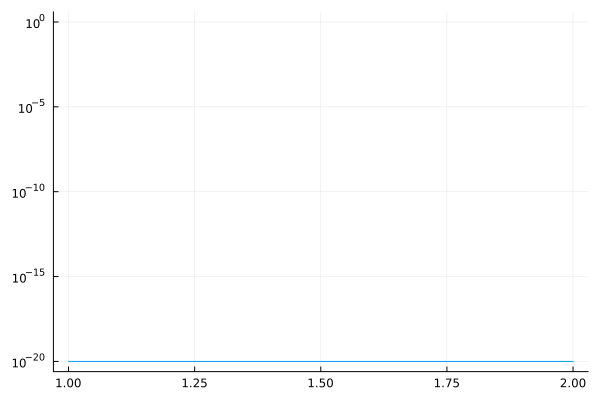

In [197]:
massrel = abs.((massConserv.-massConserv[1])/massConserv[1]).+1e-20
Plots.plot(massrel,yaxis=:log10,label=false)